<a href="https://colab.research.google.com/github/SHYXIN/100-Days-Of-ML-Code/blob/master/Copy_of_LSTM_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
df = df[5::6]
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df[:26]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


<Axes: xlabel='Date Time'>

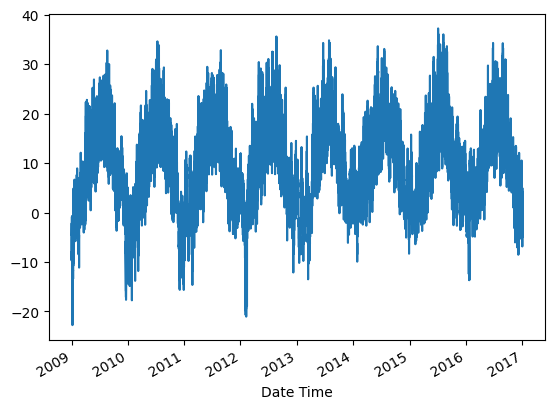

In [6]:
temp = df['T (degC)']
temp.plot()

In [7]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [9]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 39.3667 - root_mean_squared_error: 6.2743

1875/1875 [==============================] - 34s 15ms/step - loss: 39.2927 - root_mean_squared_error: 6.2684 - val_loss: 1.4515 - val_root_mean_squared_error: 1.2048
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 3.0007 - root_mean_squared_error: 1.7323

1875/1875 [==============================] - 15s 8ms/step - loss: 2.9961 - root_mean_squared_error: 1.7309 - val_loss: 0.6591 - val_root_mean_squared_error: 0.8119
Epoch 3/10
1866/1875 [============================>.] - ETA: 0s - loss: 1.1246 - root_mean_squared_error: 1.0605

1875/1875 [==============================] - 15s 8ms/step - loss: 1.1234 - root_mean_squared_error: 1.0599 - val_loss: 0.5631 - val_root_mean_squared_error: 0.7504
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.7904 - root_mean_squared_error: 0.8890

1875/1875 [==============================] - 17s 9ms/step - loss: 0.7904 - root_mean_squared_error: 0.8890 - val_loss: 0.5196 - val_root_mean_squared_error: 0.7208
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.7016 - root_mean_squared_error: 0.8376

1875/1875 [==============================] - 16s 9ms/step - loss: 0.7016 - root_mean_squared_error: 0.8376 - val_loss: 0.5170 - val_root_mean_squared_error: 0.7190
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6739 - root_mean_squared_error: 0.8209

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6738 - root_mean_squared_error: 0.8208 - val_loss: 0.4960 - val_root_mean_squared_error: 0.7043
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6616 - root_mean_squared_error: 0.8134 - val_loss: 0.4975 - val_root_mean_squared_error: 0.7053
Epoch 8/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6553 - root_mean_squared_error: 0.8095

1875/1875 [==============================] - 16s 8ms/step - loss: 0.6550 - root_mean_squared_error: 0.8093 - val_loss: 0.4905 - val_root_mean_squared_error: 0.7004
Epoch 9/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6505 - root_mean_squared_error: 0.8065 - val_loss: 0.5076 - val_root_mean_squared_error: 0.7125
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6474 - root_mean_squared_error: 0.8046

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6474 - root_mean_squared_error: 0.8046 - val_loss: 0.4894 - val_root_mean_squared_error: 0.6996


In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [14]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1875/1875 [==============================] - 7s 3ms/step


,Train Predictions,Actuals
0,-9.865771,-9.67
1,-9.625664,-9.17
2,-8.743053,-8.10
3,-7.285202,-7.66
4,-7.143310,-7.04
...,...,...
59995,6.067680,6.07
59996,7.260002,9.88
59997,12.360301,13.53
59998,16.052862,15.43


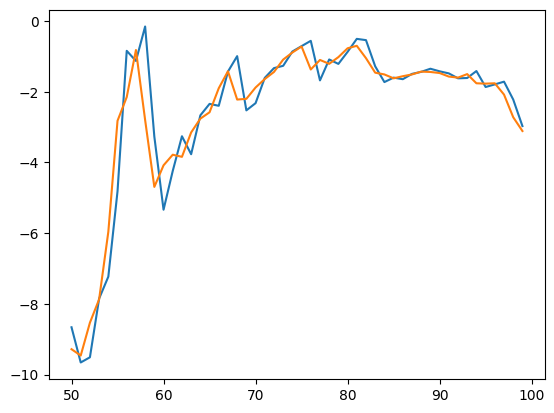

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [16]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

157/157 [==============================] - 2s 2ms/step


,Val Predictions,Actuals
0,15.575789,14.02
1,13.298514,13.67
2,13.016503,12.27
3,11.456452,11.19
4,10.368154,10.85
...,...,...
4995,17.413935,18.27
4996,17.311148,17.85
4997,17.250250,16.65
4998,15.843665,15.85


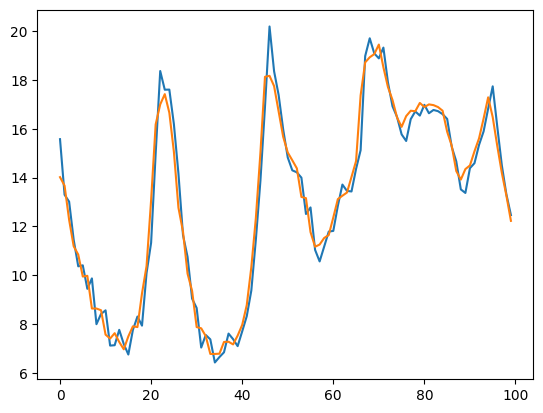

In [17]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [18]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

159/159 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,14.357814,13.99
1,13.190873,13.46
2,12.830297,12.93
3,12.453811,12.43
4,12.019649,12.17
...,...,...
5081,-0.810555,-0.98
5082,-1.227598,-1.40
5083,-1.635725,-2.75
5084,-3.011534,-2.89


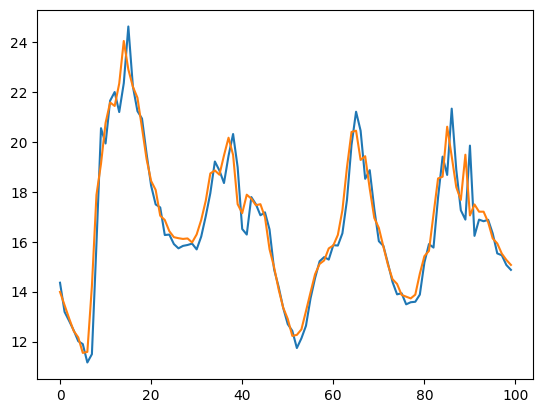

In [19]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [20]:
# Part 2

In [21]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

159/159 [==============================] - 0s 2ms/step


(      Predictions  Actuals
 0       14.357814    13.99
 1       13.190873    13.46
 2       12.830297    12.93
 3       12.453811    12.43
 4       12.019649    12.17
 ...           ...      ...
 5081    -0.810555    -0.98
 5082    -1.227598    -1.40
 5083    -1.635725    -2.75
 5084    -3.011534    -2.89
 5085    -3.093542    -3.93
 
 [5086 rows x 2 columns],
 0.6294368914578091)

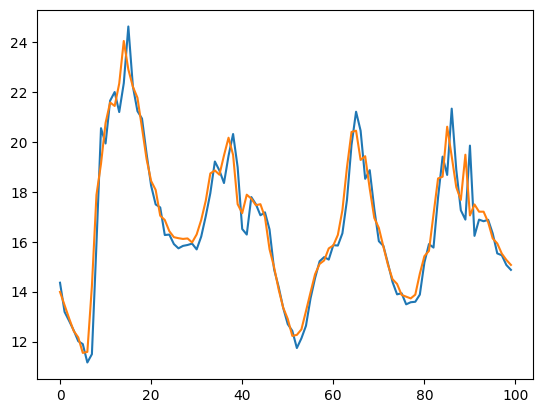

In [22]:
plot_predictions1(model1, X_test1, y_test1)

In [23]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [24]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [25]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
1849/1875 [============================>.] - ETA: 0s - loss: 9.5530 - root_mean_squared_error: 3.0908

1875/1875 [==============================] - 5s 2ms/step - loss: 9.4426 - root_mean_squared_error: 3.0729 - val_loss: 1.0490 - val_root_mean_squared_error: 1.0242
Epoch 2/10
1861/1875 [============================>.] - ETA: 0s - loss: 1.1028 - root_mean_squared_error: 1.0502

1875/1875 [==============================] - 5s 3ms/step - loss: 1.1005 - root_mean_squared_error: 1.0490 - val_loss: 0.6592 - val_root_mean_squared_error: 0.8119
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.7866 - root_mean_squared_error: 0.8869

1875/1875 [==============================] - 5s 3ms/step - loss: 0.7865 - root_mean_squared_error: 0.8869 - val_loss: 0.5423 - val_root_mean_squared_error: 0.7364
Epoch 4/10
1852/1875 [============================>.] - ETA: 0s - loss: 0.7058 - root_mean_squared_error: 0.8401

1875/1875 [==============================] - 5s 3ms/step - loss: 0.7043 - root_mean_squared_error: 0.8392 - val_loss: 0.5114 - val_root_mean_squared_error: 0.7151
Epoch 5/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.6892 - root_mean_squared_error: 0.8302

1875/1875 [==============================] - 5s 3ms/step - loss: 0.6887 - root_mean_squared_error: 0.8299 - val_loss: 0.5050 - val_root_mean_squared_error: 0.7106
Epoch 6/10
1852/1875 [============================>.] - ETA: 0s - loss: 0.6838 - root_mean_squared_error: 0.8269

1875/1875 [==============================] - 4s 2ms/step - loss: 0.6835 - root_mean_squared_error: 0.8267 - val_loss: 0.5047 - val_root_mean_squared_error: 0.7105
Epoch 7/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.6809 - root_mean_squared_error: 0.8252

1875/1875 [==============================] - 5s 3ms/step - loss: 0.6806 - root_mean_squared_error: 0.8250 - val_loss: 0.5026 - val_root_mean_squared_error: 0.7089
Epoch 8/10
1864/1875 [============================>.] - ETA: 0s - loss: 0.6800 - root_mean_squared_error: 0.8246

1875/1875 [==============================] - 5s 2ms/step - loss: 0.6799 - root_mean_squared_error: 0.8246 - val_loss: 0.5000 - val_root_mean_squared_error: 0.7071
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6752 - root_mean_squared_error: 0.8217 - val_loss: 0.5076 - val_root_mean_squared_error: 0.7125
Epoch 10/10
1857/1875 [============================>.] - ETA: 0s - loss: 0.6642 - root_mean_squared_error: 0.8150

1875/1875 [==============================] - 5s 3ms/step - loss: 0.6633 - root_mean_squared_error: 0.8144 - val_loss: 0.4908 - val_root_mean_squared_error: 0.7006


In [26]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [27]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 26.6269 - root_mean_squared_error: 5.1601

1875/1875 [==============================] - 16s 8ms/step - loss: 26.6150 - root_mean_squared_error: 5.1590 - val_loss: 1.1339 - val_root_mean_squared_error: 1.0649
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 1.9339 - root_mean_squared_error: 1.3906

1875/1875 [==============================] - 15s 8ms/step - loss: 1.9320 - root_mean_squared_error: 1.3900 - val_loss: 0.6527 - val_root_mean_squared_error: 0.8079
Epoch 3/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.9275 - root_mean_squared_error: 0.9631

1875/1875 [==============================] - 14s 8ms/step - loss: 0.9270 - root_mean_squared_error: 0.9628 - val_loss: 0.5458 - val_root_mean_squared_error: 0.7388
Epoch 4/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.7271 - root_mean_squared_error: 0.8527

1875/1875 [==============================] - 15s 8ms/step - loss: 0.7273 - root_mean_squared_error: 0.8528 - val_loss: 0.5120 - val_root_mean_squared_error: 0.7155
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6782 - root_mean_squared_error: 0.8235 - val_loss: 0.5352 - val_root_mean_squared_error: 0.7316
Epoch 6/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6623 - root_mean_squared_error: 0.8138

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6616 - root_mean_squared_error: 0.8134 - val_loss: 0.4979 - val_root_mean_squared_error: 0.7056
Epoch 7/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6532 - root_mean_squared_error: 0.8082

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6530 - root_mean_squared_error: 0.8081 - val_loss: 0.4955 - val_root_mean_squared_error: 0.7039
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6495 - root_mean_squared_error: 0.8059 - val_loss: 0.4993 - val_root_mean_squared_error: 0.7066
Epoch 9/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.6460 - root_mean_squared_error: 0.8037

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6461 - root_mean_squared_error: 0.8038 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6440 - root_mean_squared_error: 0.8025 - val_loss: 0.5443 - val_root_mean_squared_error: 0.7378


In [29]:
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [30]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [31]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


In [32]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [33]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((70085, 6, 5), (70085,))

In [34]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

In [35]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [36]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

In [37]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [38]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [39]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 35.8481 - root_mean_squared_error: 5.9873

1875/1875 [==============================] - 18s 9ms/step - loss: 35.7725 - root_mean_squared_error: 5.9810 - val_loss: 3.8578 - val_root_mean_squared_error: 1.9641
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 4.1307 - root_mean_squared_error: 2.0324

1875/1875 [==============================] - 16s 9ms/step - loss: 4.1299 - root_mean_squared_error: 2.0322 - val_loss: 1.4898 - val_root_mean_squared_error: 1.2206
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 1.5300 - root_mean_squared_error: 1.2369

1875/1875 [==============================] - 16s 8ms/step - loss: 1.5300 - root_mean_squared_error: 1.2369 - val_loss: 0.9172 - val_root_mean_squared_error: 0.9577
Epoch 4/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.9961 - root_mean_squared_error: 0.9980

1875/1875 [==============================] - 16s 9ms/step - loss: 0.9968 - root_mean_squared_error: 0.9984 - val_loss: 0.7116 - val_root_mean_squared_error: 0.8436
Epoch 5/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.7758 - root_mean_squared_error: 0.8808

1875/1875 [==============================] - 16s 8ms/step - loss: 0.7752 - root_mean_squared_error: 0.8804 - val_loss: 0.5644 - val_root_mean_squared_error: 0.7513
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6417 - root_mean_squared_error: 0.8010

1875/1875 [==============================] - 16s 9ms/step - loss: 0.6417 - root_mean_squared_error: 0.8010 - val_loss: 0.4761 - val_root_mean_squared_error: 0.6900
Epoch 7/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.5705 - root_mean_squared_error: 0.7553

1875/1875 [==============================] - 18s 10ms/step - loss: 0.5704 - root_mean_squared_error: 0.7552 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720
Epoch 8/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.5415 - root_mean_squared_error: 0.7359

1875/1875 [==============================] - 16s 9ms/step - loss: 0.5425 - root_mean_squared_error: 0.7366 - val_loss: 0.4325 - val_root_mean_squared_error: 0.6577
Epoch 9/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.5322 - root_mean_squared_error: 0.7295

1875/1875 [==============================] - 15s 8ms/step - loss: 0.5320 - root_mean_squared_error: 0.7294 - val_loss: 0.4107 - val_root_mean_squared_error: 0.6408
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5263 - root_mean_squared_error: 0.7255 - val_loss: 0.4390 - val_root_mean_squared_error: 0.6625


159/159 [==============================] - 1s 3ms/step


(      Predictions  Actuals
 0       12.908133    13.46
 1       12.495893    12.93
 2       12.111392    12.43
 3       11.844192    12.17
 4       11.993779    11.55
 ...           ...      ...
 5080    -1.162703    -0.98
 5081    -1.550497    -1.40
 5082    -1.796711    -2.75
 5083    -3.186282    -2.89
 5084    -3.331385    -3.93
 
 [5085 rows x 2 columns],
 0.5364853433362665)

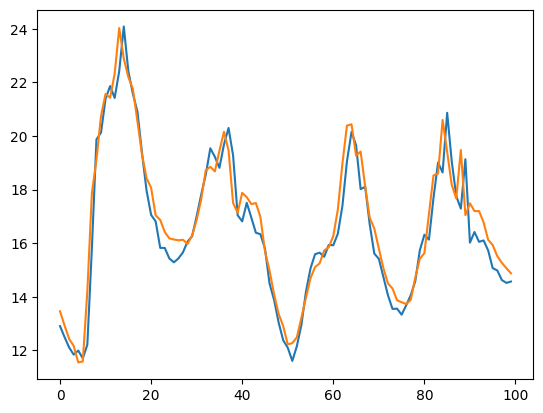

In [40]:
plot_predictions1(model4, X2_test, y2_test)

In [41]:
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis=1)
p_temp_df.head()

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [42]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [43]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape

((70084, 7, 6), (70084, 2))

In [44]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [45]:
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
  X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

In [46]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [47]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

In [48]:
model5 = Sequential()
model5.add(InputLayer((7, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18,714
Trainable params: 18,714
Non-trainable params: 0
_________________________________________________________________


In [49]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [50]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])

Epoch 1/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.1359 - root_mean_squared_error: 0.3687

1875/1875 [==============================] - 20s 9ms/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1848
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1593

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276
Epoch 3/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.1116

1875/1875 [==============================] - 16s 9ms/step - loss: 0.0124 - root_mean_squared_error: 0.1116 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0911

1875/1875 [==============================] - 19s 10ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0821

1875/1875 [==============================] - 16s 9ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 6/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0766

1875/1875 [==============================] - 16s 9ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 7/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0735

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 8/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0719

1875/1875 [==============================] - 18s 9ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0704

1875/1875 [==============================] - 18s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608


In [51]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.400899,0.412451,-0.789956,-0.793439
1,0.357297,0.353683,-0.776494,-0.763123
2,0.317171,0.323123,-0.740666,-0.721893
3,0.316043,0.250251,-0.687034,-0.652773
4,0.261431,0.254952,-0.599144,-0.652773
...,...,...,...,...
95,0.689056,0.716869,-0.418605,-0.416310
96,0.651128,0.687485,-0.419485,-0.399333
97,0.636887,0.663978,-0.401330,-0.399333
98,0.637847,0.641646,-0.388971,-0.400546


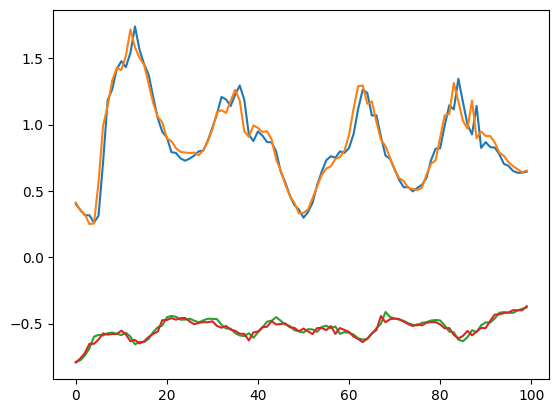

In [52]:
plot_predictions2(model5, X3_test, y3_test)

In [53]:
def postprocess_temp(arr):
  arr = (arr*temp_training_std3) + temp_training_mean3
  return arr

def postprocess_p(arr):
  arr = (arr*p_training_std3) + p_training_mean3
  return arr

In [54]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1])
  p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.831717,12.93,982.458740,982.43
1,12.460749,12.43,982.569763,982.68
2,12.119354,12.17,982.865234,983.02
3,12.109760,11.55,983.307495,983.59
4,11.645123,11.59,984.032288,983.59
...,...,...,...,...
95,15.283367,15.52,985.521118,985.54
96,14.960668,15.27,985.513855,985.68
97,14.839510,15.07,985.663574,985.68
98,14.847680,14.88,985.765503,985.67


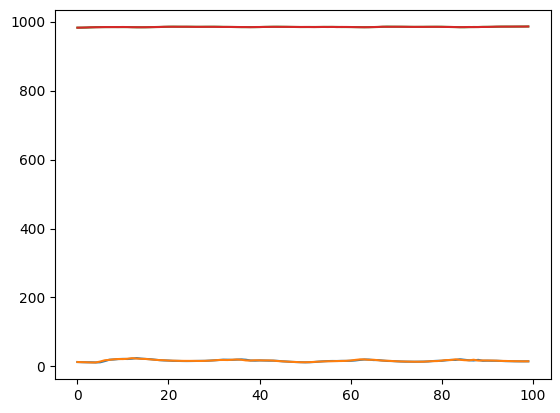

In [55]:
post_processed_df = plot_predictions2(model5, X3_test, y3_test)
post_processed_df

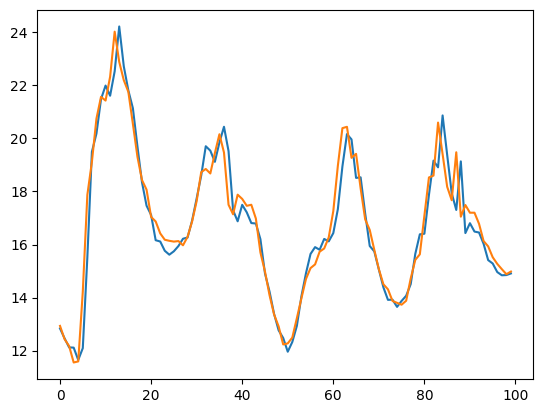

In [56]:
start, end = 0, 100
plt.plot(post_processed_df['Temperature Predictions'][start:end])
plt.plot(post_processed_df['Temperature Actuals'][start:end])

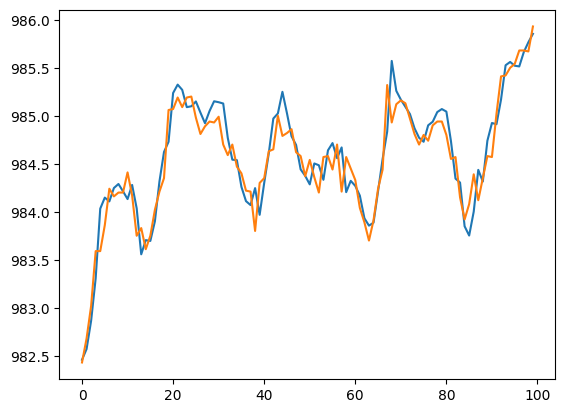

In [57]:
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])

In [58]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30,362
Trainable params: 30,362
Non-trainable params: 0
_________________________________________________________________


In [59]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [60]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.1588 - root_mean_squared_error: 0.3985

1875/1875 [==============================] - 33s 15ms/step - loss: 0.1587 - root_mean_squared_error: 0.3984 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0379 - root_mean_squared_error: 0.1947

1875/1875 [==============================] - 29s 15ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 3/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.1412

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1098
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1054

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0948

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0867

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0803

1875/1875 [==============================] - 28s 15ms/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 8/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0760

1875/1875 [==============================] - 30s 16ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 9/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0740

1875/1875 [==============================] - 30s 16ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 10/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666


In [61]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model6/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             832       
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 3080      
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
_________________________________________________________________


In [62]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])

Epoch 1/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0983 - root_mean_squared_error: 0.3135

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0980 - root_mean_squared_error: 0.3131 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 2/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.1234

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0995

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 4/10
1857/1875 [============================>.] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0894

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 5/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0836

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 6/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0801

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 7/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0776

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 8/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0760

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 9/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0746

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 10/10
1859/1875 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0737

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
